In [7]:
import os
import numpy
from scipy import integrate, linalg
import math
from matplotlib import pyplot
%matplotlib inline

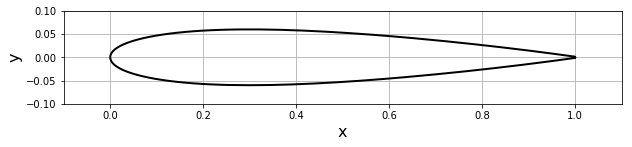

In [8]:
naca_filepath = os.path.join('naca0012.dat')
with open(naca_filepath, 'r') as infile:
    x,y = numpy.loadtxt(infile, dtype=float, unpack=True)

# plot geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

In [9]:
# define the panel class slightly differently

class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, xa
        
        self.xc, self.yc = (xa +xb)/2, (ya +yb)/2
        self.length  = math.sqrt((xb-xa)**2+(yb-ya)**2)
        
        # orientation of the panel
        if xb - xa <= 0.0:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb - xa > 0.0:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0 # tangential velocity
        self.cp = 0.0 # pressure coefficient

In [10]:
# we want to get uneven panel distribution along the airfoil surface 
# so use a circle whos diameter is the airfoil's chord length

def define_panels(x,y,N=40):
    # define the circle and its coordinates
    R = (x.max() - x.min())/2
    x_center = (x.max()+x.min())/2
    x_circle = x_center + R*numpy.cos(numpy.linspace(0.0, 2*math.pi, N+1))
    
    x_ends = numpy.copy(x_circle) # project x-coordinates onto the surface
    y_ends = numpy.empty_like(x_ends) # create the y-coordinates
    x,y = numpy.append(x, x[0]), numpy.append(y, y[0])
    
    # compute the y-coordinate of the end points
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I]) / (x[I+1]-x[I])
        b = y[I+1]-a*x[I+1]
        y_ends[i] = a*x_ends[i]+b
    y_ends[N] = y_ends[0]
        
    panels = numpy.empty(N, dtype=object)
    for i in range (N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
            
    return panels

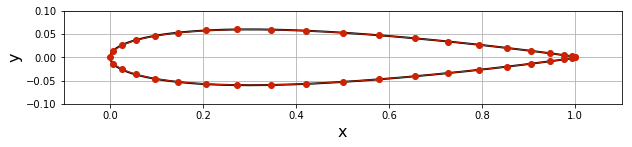

In [11]:
# discretize the geometry into panels
panels = define_panels(x,y,N=40)

# plot discretized geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

In [12]:
# create the freestream
class Freestream: 
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)

In [13]:
# define the freestream conditions
freestream = Freestream(u_inf=1.0, alpha=4.0)

In [14]:
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x - (panel.xa - numpy.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + numpy.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - numpy.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + numpy.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [15]:
def source_contribution_normal(panels):
    A=numpy.empty((panels.size, panels.size), dtype = float)
    numpy.fill_diagonal(A, 0.5)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    return A

In [16]:
def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A

In [17]:
# create the source and vortex contributions

A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [18]:
# create the kutta condition

def kutta_condition(A_source, B_votex):
    b = numpy.empty(A_source.shape[0]+1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0,:] + B_vortex[-1,:]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - numpy.sum(A_source[0,:] + A_source[-1,:])
    return b 

In [19]:
def build_singularity_matrix(A_source, B_vortex):
    A = numpy.empty((A_source.shape[0] + 1, A_source.shape[1] +1), dtype = float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = numpy.sum(B_vortex, axis = 1)
    # kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [20]:
def build_freestream_rhs(panels, freestream):
    b = numpy.empty(panels.size+1, dtype = float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf*numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[-1].beta) )
    return b

In [21]:
# create the singularity matrices

A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

# solve for the singularity matrices
strengths = numpy.linalg.solve(A,b)

#store the strengths on each panel
for i, panel in enumerate(panels):
    panel.sigma = strengths[i]

# store the circulation density
gamma = strengths[-1]

In [22]:
# want to get the pressure coefficient so we need the tangential velocity

def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size+1), dtype = float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:,-1] = -numpy.sum(A_source, axis = 1)
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha - panel.beta for panel in panels])
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    tangential_velocities = numpy.dot(A,strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [23]:
# tangential velocities at each panel center
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

# compute the pressure coefficient
def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

# surface pressure coefficient
compute_pressure_coefficient(panels, freestream)

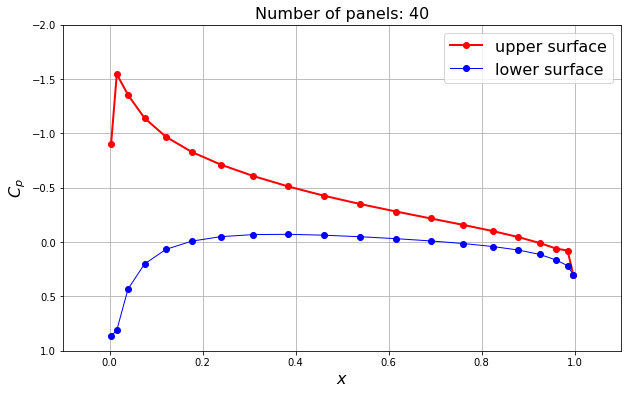

In [24]:
# plot it
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -2.0)
pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);

Here, the lift coefficient at the trailing edge of the airfoil should be = 1.0 as this is where the stagnation point should be. This isn't the case because we are taking the value at the center of each panel. If we added more points we would see the Cp value approach 1.0 at the trailing edge.

In [25]:
# check the accuracy

accuracy = sum([panel.sigma*panel.length for panel in panels])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.004606


In [26]:
# find the chord and the lift coefficient

c = abs(max(panel.xa for panel in panels) -
        min(panel.xa for panel in panels))
cl = (gamma * sum(panel.length for panel in panels) /
      (0.5 * freestream.u_inf * c))
print('lift coefficient: CL = {:0.3f}'.format(cl))

lift coefficient: CL = 0.506


Challenge Task: compute and plot the streamlines and the pressure coefficient on a cartesian grid. 